# Written Questions - Flow From Party to Answering Body

*Inspired by @philbgorman / https://cdn.rawgit.com/Mognar/sankey/master/index.html*

Documenting the generation of a Sankey diagram using Python to chart the number of responses from Answering Bodies to  questions tabled by members of the House of Commons of a particular party for the 2015/16 Parliamentary session.

In [1]:
#Quick peek at the API

#http://lda.data.parliament.uk/commonswrittenquestions.json?_view=Written+Questions&_pageSize=10&_page=0
stub='http://lda.data.parliament.uk'.strip('/')

#http://explore.data.parliament.uk/?learnmore=Commons%20Written%20Questions
#commonswrittenquestions	All Commons Written Questions
#commonswrittenquestions/answeringdepartment?q={query}	All Commons Written Questions By Answering Body
#commonswrittenquestions?mnisId={mnisId}	All Commons Written Questions By Member
#commonswrittenquestions?session={session}	All Commons Written Questions By Session
#commonswrittenquestions/tabled?startDate={startDate}&endDate={endDate}	All Commons Written Questions By Table Date
#commonswrittenquestions?uin={uin}	All Commons Written Questions By UIN
#commonswrittenquestions/{id}	Commons Written Questions by ID

In [6]:
#We're going to have to call the API somehow
import requests

#To make thinks more efficient if we do this again, cache requests
import requests_cache
requests_cache.install_cache('parlidata_cache', backend='sqlite')
#(It helps if I remember to specify a persistent backend.., doh!)

In [7]:
#Get data from URL
def getURL(url):
    print(url)
    r=requests.get(url)
    print(r.status_code)
    return r

#Should build a proper recursive loader
def loader(url):
    items=[]
    done=False
    r=getURL(url)
    while not done:
        items=items+r.json()['result']['items']
        if 'next' in r.json()['result']:
            r=getURL(r.json()['result']['next']+'&_pageSize=500')
        else: done=True
    return items

In [8]:
#Get the data for a particular session
url='{}/{}.json?session={}'.format(stub,'commonswrittenquestions','2015/16')
items=loader(url)

http://lda.data.parliament.uk/commonswrittenquestions.json?session=2015/16
200
http://lda.data.parliament.uk/commonswrittenquestions.json?session=2015/16&_page=1&_pageSize=500
200
http://lda.data.parliament.uk/commonswrittenquestions.json?session=2015/16&_page=2&_pageSize=500
200
http://lda.data.parliament.uk/commonswrittenquestions.json?session=2015/16&_page=3&_pageSize=500
200
http://lda.data.parliament.uk/commonswrittenquestions.json?session=2015/16&_page=4&_pageSize=500
200
http://lda.data.parliament.uk/commonswrittenquestions.json?session=2015/16&_page=5&_pageSize=500
200
http://lda.data.parliament.uk/commonswrittenquestions.json?session=2015/16&_page=6&_pageSize=500
200
http://lda.data.parliament.uk/commonswrittenquestions.json?session=2015/16&_page=7&_pageSize=500
200
http://lda.data.parliament.uk/commonswrittenquestions.json?session=2015/16&_page=8&_pageSize=500
200
http://lda.data.parliament.uk/commonswrittenquestions.json?session=2015/16&_page=9&_pageSize=500
200
http://lda.d

In [9]:
#Preview of the record for a single item
#As this is all JSON, maybe consider looking at https://www.sqlite.org/json1.html
#Or use mongo etc?
items[0]

{'AnswerDate': {'_datatype': 'dateTime', '_value': '2016-05-12'},
 'AnsweringBody': [{'_value': 'Prime Minister'}],
 '_about': 'http://data.parliament.uk/resources/518530',
 'dateTabled': {'_datatype': 'dateTime', '_value': '2016-05-11'},
 'questionText': 'To ask the Prime Minister, if he will clarify his recent remarks concerning Suliman Gani.',
 'tablingMember': {'_about': 'http://data.parliament.uk/members/126',
  'label': {'_value': 'Biography information for Mr Keith Simpson'}},
 'tablingMemberPrinted': [{'_value': 'Mr Keith Simpson'}],
 'title': 'House of Commons Tabled Parliamentary Question 2015/16 37017',
 'uin': '37017'}

The answer data includes a reference to the Member who tabled the question, but not their party. We need to pull that from the member database.

In [10]:
#Function to get member data back from the member API.
#Note the form of the test URL...
def memberData(memberURL):
    r=requests.get(memberURL)
    return r.json()['result']['primaryTopic']

memberData('http://lda.data.parliament.uk/members/4393.json')

{'_about': 'http://data.parliament.uk/members/4393',
 'additionalName': {'_value': 'Campbell'},
 'constituency': {'_about': 'http://data.parliament.uk/resources/144264',
  'label': {'_value': 'Cumbernauld, Kilsyth and Kirkintilloch East'}},
 'familyName': {'_value': 'McDonald'},
 'fullName': {'_value': 'Stuart C. McDonald'},
 'gender': {'_value': 'Male'},
 'givenName': {'_value': 'Stuart'},
 'homePage': 'http://stuartmcdonaldmp.com/',
 'isPrimaryTopicOf': 'http://lda.data.parliament.uk/members/4393.json',
 'label': {'_value': 'Biography information for Stuart C. McDonald'},
 'party': {'_value': 'Scottish National Party'},
 'twitter': {'_value': 'https://twitter.com/stuart_mcdonald'}}

In [11]:
#Generate a set of members who have tabled questions that have been answered
#Note that the identifier Linked Data URL doesn't link... so patch it...
members= {'{}.json'.format(i['tablingMember']['_about'].replace('http://','http://lda.')) for i in items}

#Get member data for each member
membersdata=[memberData(m) for m in members]

In [12]:
#Generate a lookup of the party from the member identifer as a dict
def getParty(memberDataURL):
    for m in membersdata:
        if m['_about']==memberDataURL:
            return m['party']['_value']
    return {}

memberparty={m['_about']:getParty(m['_about']) for m in membersdata}

In [13]:
#Get the party of the person who tabled an answered question and answering department(s)
def getPartyDept(item):
    rel=[]
    party=memberparty[item['tablingMember']['_about']]
    #Note that there may be more than one answering body, so return a list of (party,answering body) pairs
    for body in item['AnsweringBody']:
        rel.append((party,body['_value']))
    return rel

#For each answer, lookup the party of the member who tabled the question and the answering department(s)
#Use this cunning trick to collapse the nested list of responses to a flat list of (party,answering body) pairs
#http://stackoverflow.com/a/952952/454773
#[item for sublist in [[1,2],[3]] for item in sublist]
rels=[rel for s in [getPartyDept(q) for q in items] for rel in s]

In [14]:
rels[:3]

[('Conservative', 'Prime Minister'),
 ('Labour', 'Department for Business, Innovation and Skills'),
 ('Labour', 'Department for Business, Innovation and Skills')]

In [15]:
#Generate a dataframe of the pairs...
import pandas as pd
df=pd.DataFrame(rels)
df.columns=['party','answeringBody']

#Count the number of responses for each (party, answering body) pair
dfc=df.groupby(['party','answeringBody']).size().reset_index()
dfc.columns=['source','target','value']
dfc.head()

,source,target,value
0,Conservative,Attorney General,56
1,Conservative,Cabinet Office,202
2,Conservative,Church Commissioners,12
3,Conservative,"Department for Business, Innovation and Skills",430
4,Conservative,Department for Communities and Local Government,425


In [16]:
#Generate the list of dicts the Sankey widget expects
links=dfc.dropna().to_dict(orient='records')
links[:3]

[{'source': 'Conservative', 'target': 'Attorney General', 'value': 56},
 {'source': 'Conservative', 'target': 'Cabinet Office', 'value': 202},
 {'source': 'Conservative', 'target': 'Church Commissioners', 'value': 12}]

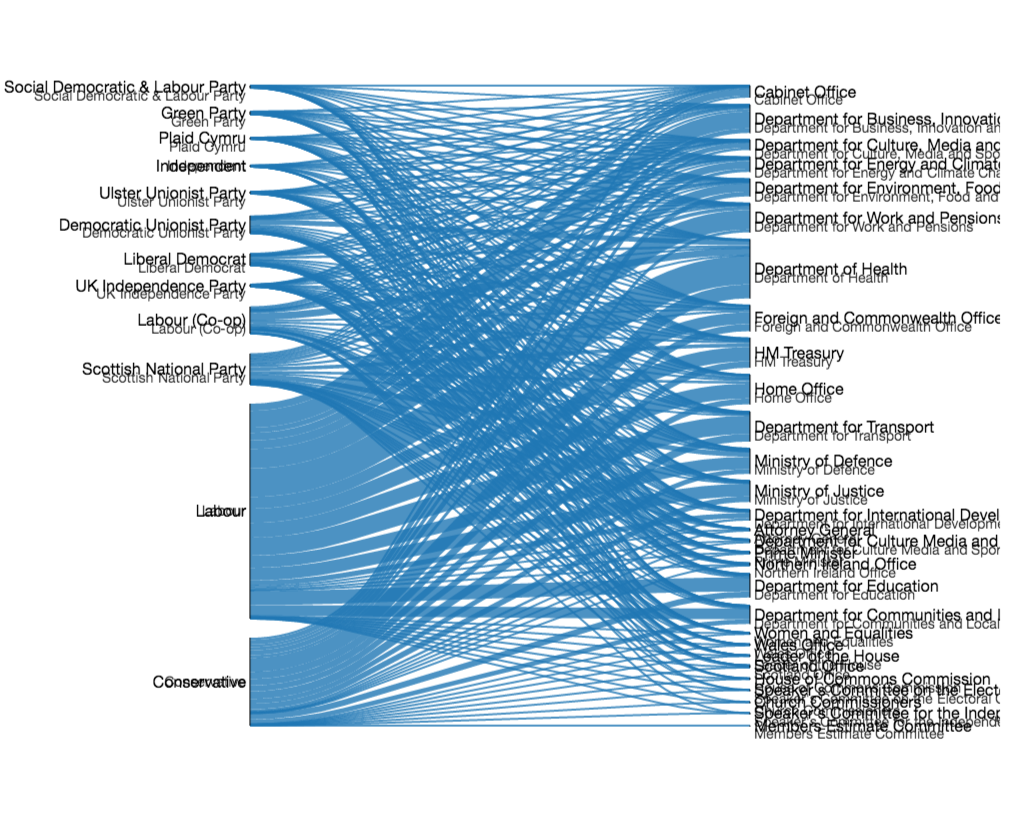

In [17]:
#And generate the Sanley diagram
from ipysankeywidget import SankeyWidget
SankeyWidget(value={'links': links},
             width=1000, height=800,margins=dict(top=0, bottom=0,left=250,right=250))